In [6]:
import os
from os.path import abspath

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

In [7]:
#loading all the data

#patient demographic
demo = pd.read_csv(abspath("../dataScienceTask/T_demo.csv"))
#medications
meds = pd.read_csv(abspath("../dataScienceTask/T_meds.csv"))
#CDK stage progress
stage = pd.read_csv(abspath("../dataScienceTask/T_stage.csv"))

#CDK clinical markers
creatinine = pd.read_csv(abspath("../dataScienceTask/T_creatinine.csv"))
DBP = pd.read_csv(abspath("../dataScienceTask/T_DBP.csv"))
SBP = pd.read_csv(abspath("../dataScienceTask/T_SBP.csv"))
HGB = pd.read_csv(abspath("../dataScienceTask/T_HGB.csv"))
glucose = pd.read_csv(abspath("../dataScienceTask/T_glucose.csv"))
ldl = pd.read_csv(abspath("../dataScienceTask/T_ldl.csv"))

In [61]:
# For this type of data with many explanatory variables, Random Forest Algorithm will give us a good accuracy rate.
# However, Logistic Regression could also provide us with a good probability output and it's more suited for larger 
# datasets with more noise.

#Preparing data 

#All data must be serialized and grouped by patient id
#age is already a numeric series
race = pd.get_dummies(demo.race).drop("Unknown", axis=1)
gender = pd.get_dummies(demo.gender)["Female"].rename({"Female":"gender"}) #-> booelan for Female gender


#clinical markers -> get difference between first and last value of marker for each patient
cre_diff = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in creatinine.groupby("id")},
                       name="creatinine")
dbp_diff = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in DBP.groupby("id")}, name="dbp")
sbp_diff = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in SBP.groupby("id")}, name="sbp")
hgb_diff = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in HGB.groupby("id")}, name="hgb")
glu_diff = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in glucose.groupby("id")}, name="glucose")
ldl_diff = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in ldl.groupby("id")}, name="ldl")

#merge clinical markers
markers = pd.concat([cre_diff,dbp_diff,sbp_diff,hgb_diff,glu_diff,ldl_diff], axis=1)
markers

#medication -> categorize by id and drugs taken(boolean)
meds_series = pd.DataFrame()
for drug_name, val in meds.groupby("drug"):
    #empty arr
    drug_arr = np.zeros(demo.id.shape, dtype=bool)
    drug_arr[val.id.unique()]=True
    
    meds_series[drug_name]=drug_arr
#meds_series

# MERGE all data including label (stage)
all_data = pd.concat([demo.age,race,gender,markers,meds_series, stage.drop("id",axis=1)],axis=1)

#all_data #-> (300,34)

#seperate true_label and false_label from stage progression
true_label = all_data[all_data.Stage_Progress] #(100,34)
false_label = all_data[~all_data.Stage_Progress] #(200,34)



In [62]:
# Split data to train and test sets
# 90:10 train-test split with balanced test set, 15 patients each for true and false,
# class_weight = balanced

true_train_bal, true_test_bal = train_test_split(true_label, test_size=15, random_state=42)
false_train_bal, false_test_bal = train_test_split(false_label, test_size=15, random_state=42)

train_set_bal = pd.concat([true_train_bal,false_train_bal])
test_set_bal = pd.concat([true_test_bal,false_test_bal])

print(train_set_bal.shape)
print(test_set_bal.shape)

# 90:10 train-test split with unbalanced test set, 
# class_weight = total observations / (number of classes * observations in class)

true_train_ub, true_test_ub = train_test_split(true_label, test_size=0.1, random_state=42)
false_train_ub, false_test_ub = train_test_split(false_label, test_size=0.1, random_state=42)

train_set_ub = pd.concat([true_train_ub,false_train_ub])
test_set_ub = pd.concat([true_test_ub,false_test_ub])

print(train_set_ub.shape)
print(test_set_ub.shape)





(270, 34)
(30, 34)
(270, 34)
(30, 34)


In [63]:
# Training the model BALANCED
rf_model_balanced = RandomForestClassifier(bootstrap=True, n_estimators=1000, oob_score=True, class_weight="balanced")
rf_model_balanced.fit(train_set_bal.drop("Stage_Progress", axis=1), train_set_bal["Stage_Progress"].values.ravel())


RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       oob_score=True)

In [64]:
# Training the model UNBALANCED
rf_model_unbalanced = RandomForestClassifier(bootstrap=True, n_estimators=1000, oob_score=True, class_weight={0:0.75, 1:1.5})
rf_model_unbalanced.fit(train_set_ub.drop("Stage_Progress", axis=1), train_set_ub["Stage_Progress"].values.ravel())

RandomForestClassifier(class_weight={0: 0.75, 1: 1.5}, n_estimators=1000,
                       oob_score=True)

In [65]:
#balanced
rf_model_balanced.oob_score_

0.7962962962962963

In [66]:
#unbalanced
rf_model_unbalanced.oob_score_

0.7962962962962963

In [67]:
#balanced
rf_model_balanced.score(test_set_bal.drop("Stage_Progress",axis=1), test_set_bal["Stage_Progress"].values.ravel())


0.7666666666666667

In [68]:
#unbalanced
rf_model_unbalanced.score(test_set_ub.drop("Stage_Progress",axis=1), test_set_ub["Stage_Progress"].values.ravel())

0.8

In [69]:
prediction_balanced = rf_model_balanced.predict(test_set_bal.drop("Stage_Progress",axis=1))
prediction_unbalanced = rf_model_unbalanced.predict(test_set_ub.drop("Stage_Progress",axis=1))

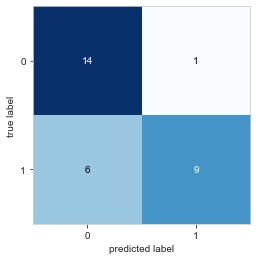

In [70]:
cm_balanced = confusion_matrix(test_set_bal["Stage_Progress"], prediction_balanced)
plot_confusion_matrix(cm_balanced)
plt.show()

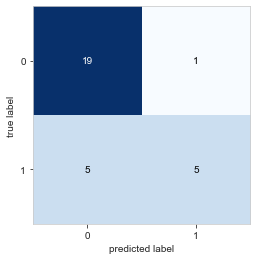

In [71]:
cm_unbalanced = confusion_matrix(test_set_ub["Stage_Progress"], prediction_unbalanced)
plot_confusion_matrix(cm_unbalanced)
plt.show()

In [72]:
#balanced
accuracy_score(test_set_bal["Stage_Progress"], prediction_balanced)



0.7666666666666667

In [73]:
#unbalanced
accuracy_score(test_set_ub["Stage_Progress"], prediction_unbalanced)


0.8

In [74]:
print("Balanced Classification\n",classification_report(test_set_bal["Stage_Progress"],prediction_balanced))

print("Unbalanced Classification\n",classification_report(test_set_ub["Stage_Progress"],prediction_unbalanced))

Balanced Classification
               precision    recall  f1-score   support

       False       0.70      0.93      0.80        15
        True       0.90      0.60      0.72        15

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.76        30
weighted avg       0.80      0.77      0.76        30

Unbalanced Classification
               precision    recall  f1-score   support

       False       0.79      0.95      0.86        20
        True       0.83      0.50      0.62        10

    accuracy                           0.80        30
   macro avg       0.81      0.72      0.74        30
weighted avg       0.81      0.80      0.78        30

